3. How can we improve the efficiency of our supply chain?
- Analyze supplier performance 
- Identify bottlenecks
    - Understand which products have high sales volumes and require more frequent restocking as bottlenecks often occur with high-demand products that are slow to restock.

In [277]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

online_retail = pd.read_csv('online_retail_clean.csv')
# drop rows with negative quantity
online_retail = online_retail[online_retail['Quantity'] > 0]
# drop rows with unit price <=0
online_retail = online_retail[online_retail['UnitPrice'] > 0]
# drop rows with country= unspecified
online_retail = online_retail[online_retail['Country'] != 'Unspecified']
# convert invoice date to datetime
online_retail['Invoice Date'] = pd.to_datetime(online_retail['Invoice Date'])
# add a new column for invoice date time 
online_retail['Invoice_DateTime'] = pd.to_datetime(online_retail['Invoice Date'].astype(str) + ' ' + online_retail['Invoice Time'].astype(str))
print(online_retail.shape)
print(f"Start date: {online_retail['Invoice Date'].min()}", f"End date: {online_retail['Invoice Date'].max()}", sep='\n')
online_retail.head()

(524356, 11)
Start date: 2010-12-01 00:00:00
End date: 2011-12-09 00:00:00


,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Invoice Date,Invoice Time,TotalPrice,Invoice_DateTime
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010-12-01,08:26:00,15.30,2010-12-01 08:26:00
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,20.34,2010-12-01 08:26:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,2010-12-01,08:26:00,22.00,2010-12-01 08:26:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,20.34,2010-12-01 08:26:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,20.34,2010-12-01 08:26:00


$$
\text{ Weekly Sales Velocity} = \frac{\text{Total Quantity Sold}}{\text{Number of Weeks Product Sold}}
$$

Weekly sales velocity is preferred to daily sales velocity as it is 
1. Smoother, less volatile, and easier to track trends
2. Can help highlight consistent issues in order fulfillment, inventory, or supplier delays.
3. Easier to track and compare supplier performance on a consistent basis.
    - If a product's sales velocity slows down significantly after a week, this could indicate a delay in supplier fulfillment.

In [278]:
# aggregate sales data by StockCode and Description to calculate the units sold per week
# identify products with consistently high or fluctuating demand as these may stress the supply chain
weekly_sales_velocity = online_retail.groupby(['StockCode', 'Description', online_retail['Invoice Date'].dt.to_period("W")])['Quantity'].sum().reset_index()
weekly_sales_velocity = weekly_sales_velocity.rename(columns={'Invoice Date': 'Date'})
# calculate the average units sold per week i.e. sales velocity
weekly_sales_velocity['Sales Velocity'] = weekly_sales_velocity['Quantity'] / weekly_sales_velocity.groupby('StockCode')['Date'].transform('nunique')
# aggregate sales data by StockCode and Description to identify high demand products
weekly_sales_velocity_product = weekly_sales_velocity.groupby(['StockCode', 'Description'])['Sales Velocity'].mean().reset_index().sort_values('Sales Velocity', ascending=False)
# top 10 products with highest weekly sales velocity
weekly_sales_velocity_product.reset_index().head(10)

,index,StockCode,Description,Sales Velocity
0,2668,23843,"PAPER CRAFT , LITTLE BIRDIE",80995.000000
1,2873,47556B,TEA TIME TEA TOWELS,650.000000
2,2583,23552,BICYCLE PUNCTURE REPAIR KIT,207.000000
3,2507,23498,CLASSIC BICYCLE CLIPS,182.222222
4,2608,23581,JUMBO BAG PAISLEY PARK,102.448980
5,2609,23582,VINTAGE DOILY JUMBO BAG RED,98.000000
6,38,16043,POP ART PUSH DOWN RUBBER,98.000000
7,236,20827,GOLD APERITIF GLASS,88.000000
8,2123,23166,MEDIUM CERAMIC TOP STORAGE JAR,76.204102
9,80,17001,HEAVENS SCENT FRAGRANCE OILS ASSTD,72.000000


Segment products into low,medium and high velocity products to focus on key bottlenecks or stock issues in specific products.
- Low velocity: Products that need to be monitored closely, perhaps considered for discontinuation, promotions, or better demand forecasting
- Medium velocity: Products with consistent but not exceptional demand that may benefit from supply chain optimization, better inventory management, or forecasting
- High velocity: Products that need high priority for stock replenishment, monitoring for potential stockouts, and possible supplier negotiations

In [279]:
# segment products into high, medium and low demand based on sales velocity
low_threshold = weekly_sales_velocity_product['Sales Velocity'].quantile(0.25)
high_threshold = weekly_sales_velocity_product['Sales Velocity'].quantile(0.75)
weekly_sales_velocity_product["Sales Velocity Category"]= weekly_sales_velocity_product["Sales Velocity"].apply(lambda x: "High" if x > high_threshold else ("Low" if x < low_threshold else "Medium"))
weekly_sales_velocity_product

,StockCode,Description,Sales Velocity,Sales Velocity Category
2668,23843,"PAPER CRAFT , LITTLE BIRDIE",80995.000000,High
2873,47556B,TEA TIME TEA TOWELS,650.000000,High
2583,23552,BICYCLE PUNCTURE REPAIR KIT,207.000000,High
2507,23498,CLASSIC BICYCLE CLIPS,182.222222,High
2608,23581,JUMBO BAG PAISLEY PARK,102.448980,High
...,...,...,...,...
4139,C2,CARRIAGE,0.059142,Low
702,21627,ELEPHANT CARNIVAL POUFFE,0.057851,Low
3514,84997a,GREEN 3 PIECE POLKADOT CUTLERY SET,0.047619,Low
1685,22776,"CAKESTAND, 3 TIER, LOVEHEART",0.037736,Low


For simplicity, assume `time_gap` is solely due to supply chain inefficiency and not weakened demand from consumers

In [280]:
# Calculate the time gap between consecutive purchases of each product (StockCod & Description)
online_retail['Prev_Invoice_Date'] = online_retail.groupby("StockCode")['Invoice Date'].shift(1)
online_retail['Time_Gap'] = (online_retail['Invoice Date'] - online_retail['Prev_Invoice_Date']).dt.days

# Filter out rows where there's no previous invoice (i.e., first purchase for each product)
stockouts_and_delays = online_retail[online_retail['Time_Gap']>0]
stockouts_and_delays.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Invoice Date,Invoice Time,TotalPrice,Invoice_DateTime,Prev_Invoice_Date,Time_Gap
3065,536598,22178,VICTORIAN GLASS HANGING T-LIGHT,24,1.25,13090.0,United Kingdom,2010-12-02,07:48:00,30.0,2010-12-02 07:48:00,2010-12-01,1.0
3067,536599,22968,ROSE COTTAGE KEEPSAKE BOX,8,8.50,15694.0,United Kingdom,2010-12-02,07:49:00,68.0,2010-12-02 07:49:00,2010-12-01,1.0
3068,536599,22727,ALARM CLOCK BAKELIKE RED,4,3.75,15694.0,United Kingdom,2010-12-02,07:49:00,15.0,2010-12-02 07:49:00,2010-12-01,1.0
3069,536599,22726,ALARM CLOCK BAKELIKE GREEN,12,3.75,15694.0,United Kingdom,2010-12-02,07:49:00,45.0,2010-12-02 07:49:00,2010-12-01,1.0
3070,536599,84945,MULTI COLOUR SILVER T-LIGHT HOLDER,36,0.85,15694.0,United Kingdom,2010-12-02,07:49:00,30.6,2010-12-02 07:49:00,2010-12-01,1.0


Calculate stockout rates for low,medium and high velocity products wth varying threshold for each category bwfore flagging the product as stockout. 
$$
\text{Stockout Rate} = \frac{\text{Total Stockouts}}{\text{Total Purchases}} \
$$

In [281]:
# high velocity products
high_velocity_products = weekly_sales_velocity_product[weekly_sales_velocity_product['Sales Velocity Category'] == 'High']
high_velocity_data = stockouts_and_delays[stockouts_and_delays['StockCode'].isin(high_velocity_products['StockCode'])]
# drop stock code with less than (5*12months) purchases i.e. only look at products with consistent demand
high_velocity_data = high_velocity_data.groupby('StockCode').filter(lambda x: len(x) > 60)
# calculate stockout/delays for high velocity products
threshold_high=5
high_velocity_data["Stockout_Flag"]=high_velocity_data["Time_Gap"].apply(lambda x: "Yes" if x > threshold_high else "No")
# calculate stockout rate for high velocity products
high_velocity_stockout_rate = high_velocity_data.groupby('StockCode').agg(
    total_purchases=('StockCode', 'count'),
    total_stockouts=('Stockout_Flag', lambda x: (x == 'Yes').sum())
).reset_index()
high_velocity_stockout_rate['Stockout Rate'] = high_velocity_stockout_rate['total_stockouts'] / high_velocity_stockout_rate['total_purchases']
# remove products with no stockouts
high_velocity_stockout_rate = high_velocity_stockout_rate[high_velocity_stockout_rate['Stockout Rate'] > 0]
print(f"Average stockout rate for high velocity products: {high_velocity_stockout_rate['Stockout Rate'].mean()}")
high_velocity_stockout_rate.sort_values('Stockout Rate', ascending=False)

Average stockout rate for high velocity products: 0.05047686570493121


,StockCode,total_purchases,total_stockouts,Stockout Rate
238,22985,84,26,0.309524
445,84212,91,22,0.241758
6,16219,80,19,0.237500
193,22710,87,19,0.218391
273,23160,63,13,0.206349
...,...,...,...,...
42,21212,297,1,0.003367
466,85099B,299,1,0.003344
454,84879,299,1,0.003344
142,22423,300,1,0.003333


In [282]:
# medium velocity products
medium_velocity_products = weekly_sales_velocity_product[weekly_sales_velocity_product['Sales Velocity Category'] == 'Medium']
medium_velocity_data = stockouts_and_delays[stockouts_and_delays['StockCode'].isin(medium_velocity_products['StockCode'])]
# drop stock code with less than (4*12) purchases i.e. only look at products with consistent demand
medium_velocity_data = medium_velocity_data.groupby('StockCode').filter(lambda x: len(x) > 48)
# calculate stockout/delays for medium velocity products
threshold_medium=10
medium_velocity_data["Stockout_Flag"]=medium_velocity_data["Time_Gap"].apply(lambda x: "Yes" if x > threshold_medium else "No")
# calculate stockout rate for medium velocity products
medium_velocity_stockout_rate = medium_velocity_data.groupby('StockCode').agg(
    total_purchases=('StockCode', 'count'),
    total_stockouts=('Stockout_Flag', lambda x: (x == 'Yes').sum())
).reset_index()
medium_velocity_stockout_rate['Stockout Rate'] = medium_velocity_stockout_rate['total_stockouts'] / medium_velocity_stockout_rate['total_purchases']
# remove products with no stockouts
medium_velocity_stockout_rate = medium_velocity_stockout_rate[medium_velocity_stockout_rate['Stockout Rate'] > 0]
print(f"Average stockout rate for medium velocity products: {medium_velocity_stockout_rate['Stockout Rate'].mean()}")
medium_velocity_stockout_rate.sort_values('Stockout Rate', ascending=False)

Average stockout rate for medium velocity products: 0.05689741037771296


,StockCode,total_purchases,total_stockouts,Stockout Rate
188,21520,50,15,0.300000
925,35924,57,16,0.280702
1027,84993A,50,14,0.280000
460,22304,52,14,0.269231
174,21442,50,13,0.260000
...,...,...,...,...
376,22139,268,1,0.003731
68,21034,273,1,0.003663
246,21754,280,1,0.003571
1100,POST,282,1,0.003546


In [283]:
# low velocity products
low_velocity_products = weekly_sales_velocity_product[weekly_sales_velocity_product['Sales Velocity Category'] == 'Low']
low_velocity_data = stockouts_and_delays[stockouts_and_delays['StockCode'].isin(low_velocity_products['StockCode'])]
# drop stock code with less than (2*12 months) purchases i.e. only look at products with consistent demand
low_velocity_data = low_velocity_data.groupby('StockCode').filter(lambda x: len(x) > 24 )
# calculate stockout/delays for low velocity products
threshold_low=15
low_velocity_data["Stockout_Flag"]=low_velocity_data["Time_Gap"].apply(lambda x: "Yes" if x > threshold_low else "No")
# calculate stockout rate for low velocity products
low_velocity_stockout_rate = low_velocity_data.groupby('StockCode').agg(
    total_purchases=('StockCode', 'count'),
    total_stockouts=('Stockout_Flag', lambda x: (x == 'Yes').sum())
).reset_index()
low_velocity_stockout_rate['Stockout Rate'] = low_velocity_stockout_rate['total_stockouts'] / low_velocity_stockout_rate['total_purchases']
# remove products with no stockouts
low_velocity_stockout_rate = low_velocity_stockout_rate[low_velocity_stockout_rate['Stockout Rate'] > 0]
print(f"Average stockout rate for low velocity products: {low_velocity_stockout_rate['Stockout Rate'].mean()}")
low_velocity_stockout_rate.sort_values('Stockout Rate', ascending=False)


Average stockout rate for low velocity products: 0.10844670566303245


,StockCode,total_purchases,total_stockouts,Stockout Rate
41,20763,25,11,0.440000
630,90214G,25,11,0.440000
54,20794,26,10,0.384615
340,22825,26,10,0.384615
194,21973,28,10,0.357143
...,...,...,...,...
82,21116,159,1,0.006289
248,22361,163,1,0.006135
530,84792,164,1,0.006098
499,82567,192,1,0.005208


Analysing by Country
- Explore correlation between total quantity sold and stockout rates (supply chain efficiency)
- Identifying Growth Opportunities: Emerging markets & regions


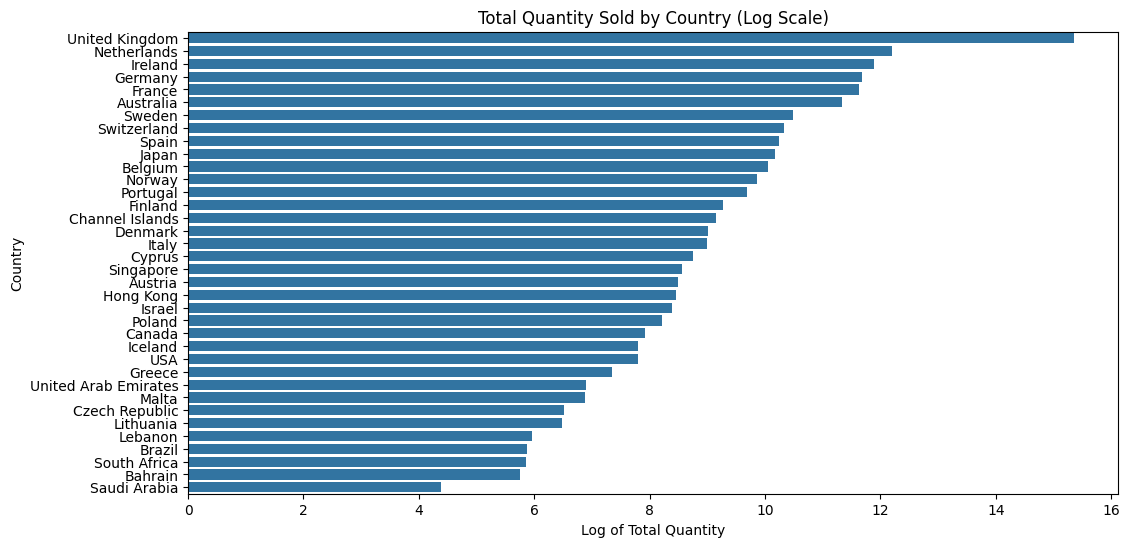

In [284]:
# analyse supplier performance by country  
country_performance = online_retail.groupby(['Country'])['Quantity'].sum().reset_index()
# Log transformation
country_performance['Log Quantity'] = np.log(country_performance['Quantity'])

plt.figure(figsize=(12, 6))
sns.barplot(x='Log Quantity', y='Country', data=country_performance.sort_values('Log Quantity', ascending=False))
plt.title('Total Quantity Sold by Country (Log Scale)')
plt.xlabel('Log of Total Quantity')
plt.ylabel('Country')
plt.show()

In [285]:
# merge low medium and high velocity stockout data 
summary_velocity=pd.concat([low_velocity_data,medium_velocity_data,high_velocity_data])

# aggregate stockout rates by country
country_stockout_rate = summary_velocity.groupby('Country')['Stockout_Flag'].value_counts(normalize=True).unstack(fill_value=0)
country_stockout_rate = country_stockout_rate['Yes']  # Focus on "Yes" stockout flag

# calculate average time gaps per country
country_time_gaps = summary_velocity.groupby('Country')['Time_Gap'].mean()

country_performance_velocity = pd.DataFrame({
    'Stockout Rate': country_stockout_rate,
    'Avg Time Gap (Days)': country_time_gaps
})


In [286]:
# summary statistics by country
supplier_performance = online_retail.groupby(['Country', 'StockCode'])['Quantity'].sum().reset_index()
supplier_performance_country = supplier_performance.groupby('Country')['Quantity'].agg(['sum', 'mean', 'count']).reset_index()
supplier_performance_country.columns = ['Country', 'Total Quantity', 'Average Quantity per StockCode', 'Number of Products']
supplier_performance_country.sort_values('Total Quantity', ascending=False)

,Country,Total Quantity,Average Quantity per StockCode,Number of Products
35,United Kingdom,4646886,1188.461893,3910
23,Netherlands,200361,256.216113,782
16,Ireland,147007,74.698679,1968
12,Germany,119154,71.606971,1664
11,France,112060,72.671855,1542
0,Australia,83891,140.051753,599
31,Sweden,36078,138.229885,261
32,Switzerland,30617,31.305726,978
30,Spain,27933,25.603116,1091
19,Japan,26016,121.004651,215


A correlation value close to 0 suggests that the two variables (stockout rate and quantity sold) are not related in any meaningful way.

In this case, the very weak positive correlation of 0.05 implies that stockouts do not have a significant impact on sales performance in different countries, suggesting that while stockouts occur, they are not preventing sales from happening at the same rate, possibly due to customers purchasing other products or alternatives when their desired product is out of stock.

Another reason could also be the varied supply chain performance across countries. Some countries might have robust, reliable logistics and supply chains that minimize stockouts while in other countries, stockouts are more common but do not significantly affect overall sales due to alternative products or lower demand volatility.

Other factors affecting quantity sold such as marketing, product popularity, seasonal demand, or pricing could be affecting total sales in a way that overpowers the impact of stockouts.

Correlation between Stockout Rate and Total Quantity Sold: 0.05


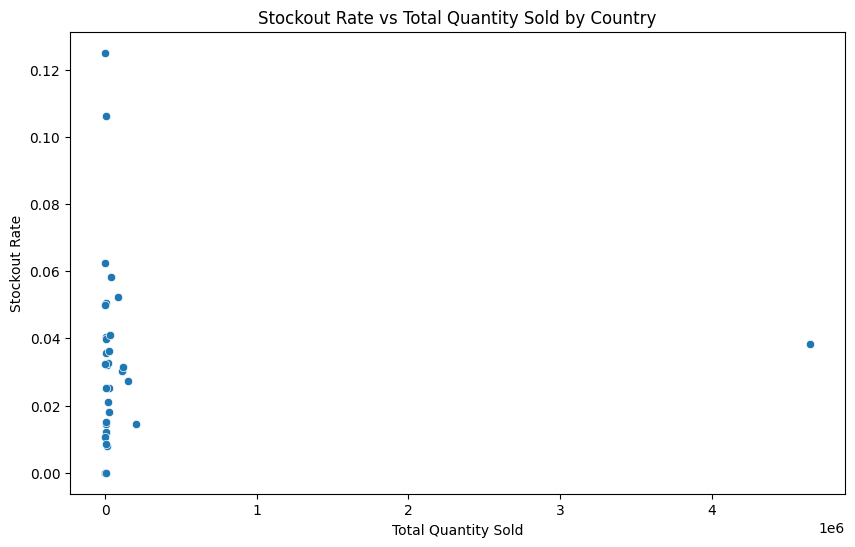

In [287]:
# merge country_performance_velocity and supplier_performance_country
country_performance = pd.merge(country_performance_velocity, supplier_performance_country, on='Country')

# calculate correlation between stockout rate and total quantity sold
correlation = country_performance['Stockout Rate'].corr(country_performance['Total Quantity'])
print(f"Correlation between Stockout Rate and Total Quantity Sold: {correlation:.2f}")

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Total Quantity', y='Stockout Rate', data=country_performance)
plt.title('Stockout Rate vs Total Quantity Sold by Country')
plt.xlabel('Total Quantity Sold')
plt.ylabel('Stockout Rate')
plt.show()

Analysing by Stock Code
- Focuses on individual products to determine which specific items are performing well or poorly.
- Helps identify bestsellers and underperformers, allowing for targeted inventory management and marketing strategies for specific products.
- Enables further analysis of product categories when necessary i.e. trends within categories like electronics, clothing, etc. 
- Analyzing performance by StockCode allows for assessing the effectiveness of promotions or changes made to specific products, together with price elasticity analysis from Question 2.

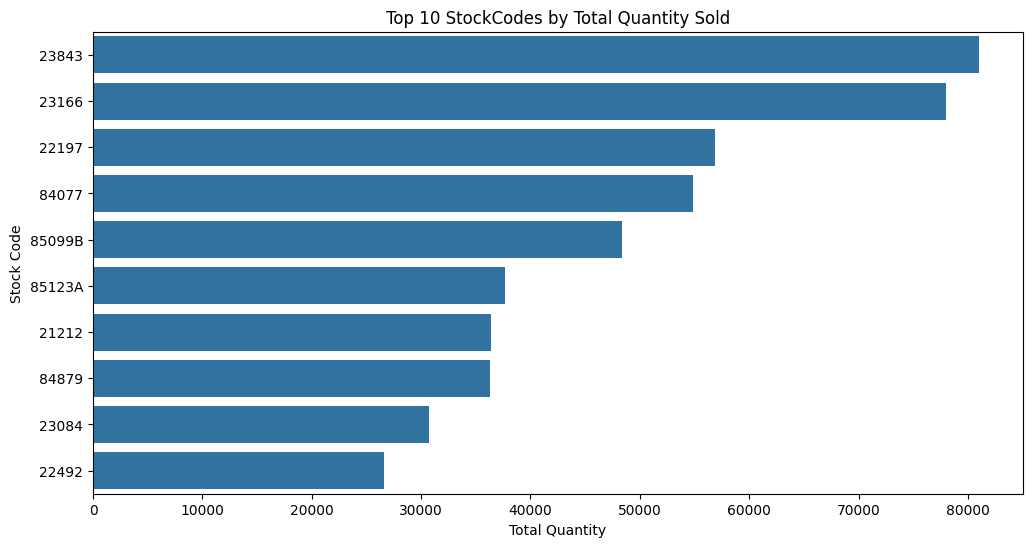

In [288]:
# analyse perfromance by stock code 
stock_code_performance = online_retail.groupby('StockCode')['Quantity'].sum().reset_index()
top_stock_code_performance = stock_code_performance.sort_values(by='Quantity', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x='Quantity', y='StockCode', data=top_stock_code_performance)
plt.title('Top 10 StockCodes by Total Quantity Sold')
plt.xlabel('Total Quantity')
plt.ylabel('Stock Code')
plt.show()

- Explore potential reasons for underperformance of using `bottom_stock_code_performance`
    * Lack of marketing or awareness
    * Poor product quality or customer feedback
    * Pricing issues or high competition (refer to question 2)
- Targeted Marketing Strategies: Advertisements or promotions such as bundles and discounts to boost sales of underperforming products
- Inventory Management: If certain products consistently underperform, consider reducing stock levels or discontinuing them 
- Supplier Relationships: If underperforming products are linked to specific suppliers, evaluate whether to continue those partnerships if given data on supplier 

In [289]:
# underperforming stock codes (bottom 25th percentile)
low_stock_code_performance = stock_code_performance[stock_code_performance['Quantity'] < stock_code_performance['Quantity'].quantile(0.25)]
low_stock_code_performance

,StockCode,Quantity
3,10123C,5
4,10124A,16
5,10124G,17
23,15056p,33
28,15060b,3
...,...,...
3911,gift_0001_20,10
3912,gift_0001_30,7
3913,gift_0001_40,3
3914,gift_0001_50,4


Analyze and engage frequent high-value customers to boost sales for low velocity products to improve turnover 

In [290]:
# group by CustomerID to calculate total spending and purchase frequency
customer_analysis = online_retail.groupby('CustomerID').agg({
    'TotalPrice': 'sum',  # Total spending
    'InvoiceNo': 'count'   # Frequency of purchases
}).reset_index()

# rename columns
customer_analysis.columns = ['CustomerID', 'TotalSpending', 'Frequency']
customer_analysis = customer_analysis.sort_values(by='TotalSpending', ascending=False)

customer_analysis.head()

,CustomerID,TotalSpending,Frequency
1686,14646.0,280206.02,2076
4195,18102.0,259657.30,431
3722,17450.0,194390.79,336
3002,16446.0,168472.50,3
1876,14911.0,143711.17,5670


3. How can we improve the efficiency of our supply chain?
- Optimize order fulfillment processes to reduce delivery times.
    1. Analyse the order placements by hour, week, and months of the year to better forecast peak periods for sales. This allows us to identify potential bottlenecks in the order fulfillment process and make data-driven adjustments to optimize supply chain efficiency, ensuring a smooth and timely delivery experience for customers during both high and low demand periods
    2. Analyse product-level order fulfillment times based on low, medium, high velocity products and its associated stockout rates as calculated in the identification of bottlenecks above. 

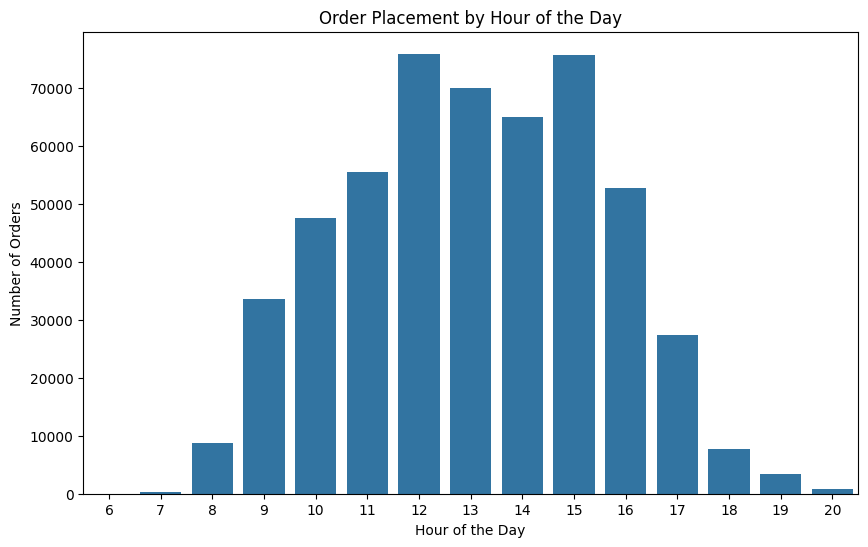

In [291]:
# analyse order placement patterns to identify peak 
# by hour of the day
online_retail['Invoice_Hour'] = online_retail['Invoice_DateTime'].dt.hour
order_by_hour = online_retail.groupby('Invoice_Hour').size()
plt.figure(figsize=(10,6))
sns.barplot(x=order_by_hour.index, y=order_by_hour.values)
plt.title('Order Placement by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Orders')
plt.show()

/var/folders/3t/3zbvgxf52kb8zp5dkwm_p35m0000gn/T/ipykernel_8536/1781408266.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  order_by_dayofweek = online_retail.groupby('Invoice_DayofWeek').size()


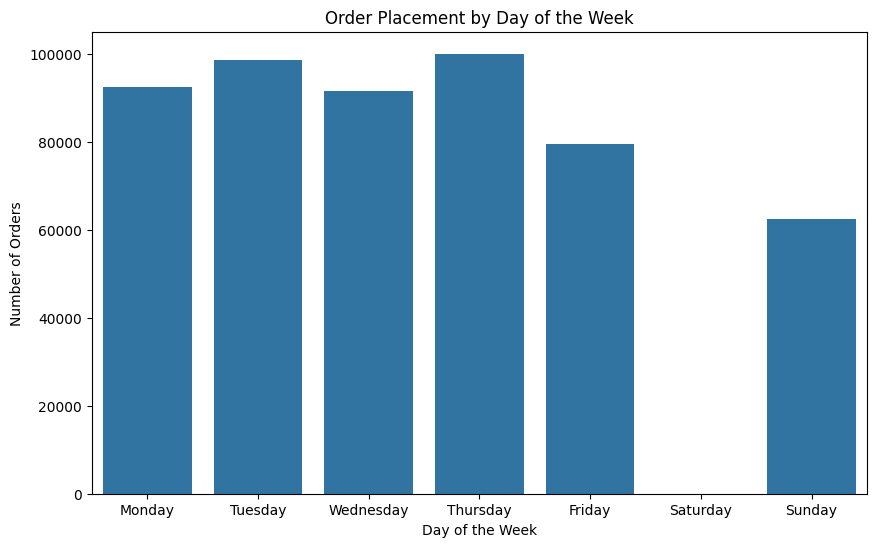

In [292]:
# by day of the week
online_retail['Invoice_DayofWeek'] = online_retail['Invoice_DateTime'].dt.dayofweek
# name the days of the week
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
online_retail['Invoice_DayofWeek'] = online_retail['Invoice_DayofWeek'].apply(lambda x: day_names[x])
# order the graph in order of the days of the week
online_retail['Invoice_DayofWeek'] = pd.Categorical(online_retail['Invoice_DayofWeek'], categories=day_names, ordered=True)
order_by_dayofweek = online_retail.groupby('Invoice_DayofWeek').size()
plt.figure(figsize=(10,6))
sns.barplot(x=order_by_dayofweek.index, y=order_by_dayofweek.values)
plt.title('Order Placement by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Orders')
plt.show()

There are lesser orders placed over the weekends compared to other days of the week. This can be due to factors like customer behavior, reduced business operations during weekends or slower shipping times. This information is helpful in optimising staffing, inventory management and targeted marketing efforts to boost sales during the weekend as well as adjusting shipping and fulfillment strategies to ensure timely delivery for customers.

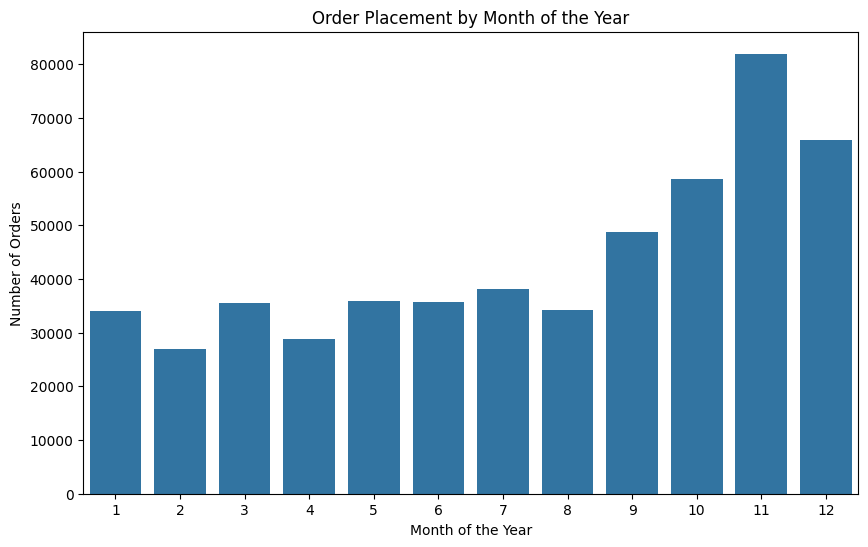

In [293]:
# by month of the year
online_retail['Invoice_Month'] = online_retail['Invoice_DateTime'].dt.month
order_by_month = online_retail.groupby('Invoice_Month').size()
plt.figure(figsize=(10,6))
sns.barplot(x=order_by_month.index, y=order_by_month.values)
plt.title('Order Placement by Month of the Year')
plt.xlabel('Month of the Year')
plt.ylabel('Number of Orders')
plt.show()

The peak period for consumer orders typically occurs during Q4, especially during the months of November and December. This surge in demand can be largely attributed to the holiday season, when consumers are more inclined to shop for gifts and take advantage of seasonal promotions. Additionally, major shopping events like Singles' Day (11.11), Black Friday, and Cyber Monday significantly contribute to this increase in orders. These events are not only marked by deep discounts and promotions but also by a cultural shift in consumer behavior, with the anticipation of large sales events to make holiday purchases. As a result, Q4 becomes a critical period for retailers, requiring careful planning and optimized supply chain strategies to manage the higher order volume, ensure timely deliveries, and maintain customer satisfaction.

In conclusion, we have successfully analyzed supplier performance and identified bottlenecks by evaluating weekly sales velocity, stockout rates, and supplier performance across different countries and product categories. These insights allow us to pinpoint underperforming products and potential supply chain inefficiencies. For optimizing order fulfillment and reducing delivery times, we identified peak order placement periods, enabling better inventory planning and resource allocation. By focusing on product-level fulfillment and demand patterns, we can prepare more effectively for high-traffic periods. These strategies will help improve operational efficiency, reduce delays, and enhance overall supply chain performance.